# HLA overlap determines (near-)sharing of TCRs

Here, we are looking at coincidences across different donors, this means TCRs that are shared across people.

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyrepseq as prs
import pyrepseq.plotting as pp

from lib import *

plt.style.use('tcrspace.mplstyle')

bins = np.arange(34)
data_dir = f'{data_directory}/tanno/'

In [2]:
dfs = {f : pd.read_csv(f'{data_dir}/pruned/pdist_{f}.csv') for f in tannofiles}

In [3]:
# read in HLA information
meta = pd.read_csv('data/metadata_tanno.csv', na_values='Blank')
metric = prs.overlap_coefficient
hla_columns = meta.columns[meta.columns.str.contains('HLA')]
hladist_condensed = prs.pdist(meta[hla_columns].to_numpy(),
                              metric=metric, dtype=np.float)
dfhladist = pd.DataFrame(prs.squareform(hladist_condensed),
                         columns=meta['Subject ID'], index=meta['Subject ID'])
hla_columns_mhcii = meta.columns[meta.columns.str.contains('HLA-D')]
hladist_condensed_mhcii = prs.pdist(meta[hla_columns_mhcii].to_numpy(),
                                    metric=metric, dtype=np.float)
dfhladist_mhcii = pd.DataFrame(prs.squareform(hladist_condensed_mhcii),
                               columns=meta['Subject ID'], index=meta['Subject ID'])

In [4]:
def aggregate(condition):
    n = 0
    cab_tot = np.zeros(len(bins))
    fab_ind_tot = np.zeros(len(bins))
    for name1, name2 in itertools.combinations(tannofiles, 2):
        name1s, name2s = name1.split(' ')[0], name2.split(' ')[0]
        if not condition(name1s, name2s, name1, name2):
            continue
        df = pd.read_csv(f'{data_dir}/pruned/cdist_{name1}_{name2}.csv')
        fab = df['freq_pair']
        cab = df['count_pair']
        n += 1
        cab_tot += cab
        fa = df['freq_alpha']
        fb = df['freq_beta']
        fab_ind = np.convolve(fa, fb, mode='full')[:fab.shape[0]]
        fab_ind_tot += fab_ind
    return cab_tot, fab_ind_tot/n

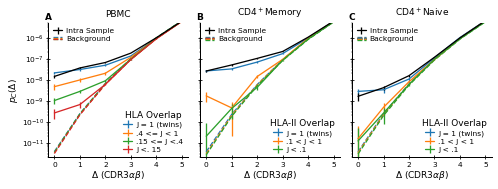

In [5]:
J_bins = [-0.05, 0.0, 0.05, 0.15, 0.4, 0.9, 1.1]

fig, axes = plt.subplots(figsize=(7.0, 2.7), ncols=3, sharex=True, sharey=True)

ax = axes[0]

def overall_filter(name1s, name2s, name1, name2):
    return ((not 'naive' in name1) and (not 'naive' in name2)
           and (not 'memory' in name1) and (not 'memory' in name2)
           and name1s!=name2s)

dfhla = dfhladist

cabs = []
ls = []
for label, extra_filter in [
    ('J = 1 (twins)', lambda n1s, n2s, n1, n2: dfhla.loc[n1s, n2s] == 1.0),
    ('.4 <= J < 1', lambda n1s, n2s, n1, n2: (dfhla.loc[n1s, n2s] < 1.0) and (dfhla.loc[n1s, n2s] >= J_bins[-3])),
    ('.15 <= J <.4', lambda n1s, n2s, n1, n2: (dfhla.loc[n1s, n2s] >= J_bins[-4]) and (dfhla.loc[n1s, n2s] < J_bins[-3])),
    ('J <. 15', lambda n1s, n2s, n1, n2: (dfhla.loc[n1s, n2s] >  J_bins[0]) and (dfhla.loc[n1s, n2s] <  J_bins[-4]))]:
    cab, fab_ind = aggregate(lambda name1s, name2s, name1, name2: (overall_filter(name1s, name2s, name1, name2)
                                                     and extra_filter(name1s, name2s, name1, name2)))
    cabs.append(list(cab))
    e = ax.errorbar(bins, cab/np.sum(cab), cab**.5/np.sum(cab), fmt='-', label=label)
    y = cab/np.sum(cab)
    yerr = cab**.5/np.sum(cab)
#    ax.fill_between(bins, y-yerr, y+yerr, alpha=.5)
    l, = ax.plot(bins, fab_ind, color=e.lines[0].get_color(), ls='--')
    ls.append(l)
cabs_sum = np.array(cabs)

# Now let's plot the average intra repertoire distribution for reference:
Cab = []
for filename, df in dfs.items():
    if 'naive' in filename or 'memory' in filename:
        continue
    # filter non twin pairs
    if not (('1' in filename) or ('2' in filename)):
        continue
    Cab.append(df['count_pair'])
cab = np.sum(Cab, axis=0)
y = cab/np.sum(cab)
yerr = cab**.5/np.sum(cab)
x = np.arange(len(y))
#f = ax.fill_between(x, y-yerr, y+yerr, alpha=.5, color='k')
e = ax.errorbar(x, y, yerr, fmt='-', color='k')

legend2 = ax.legend([e,tuple(ls)], ["Intra Sample", 'Background'], loc='upper left', fontsize='small',
                   handler_map={tuple: pp.HandlerTupleOffset(horizontal=False)})
ax.legend(loc='lower right', title='HLA Overlap', fontsize='small')
ax.add_artist(legend2)
ax.set_ylabel('$p_C(\Delta)$')
ax.set_title('PBMC')


for ax, which_one in zip(axes[1:], ['memory','naive']):

    def overall_filter(name1s, name2s, name1, name2):
        return ((which_one in name1) and (which_one in name2)
               and name1s!=name2s)

    dfhla = dfhladist_mhcii

    for label, extra_filter in [
        ('J = 1 (twins)', lambda n1s, n2s, n1, n2: dfhla.loc[n1s, n2s] == 1.0),
        ('.1 < J < 1', lambda n1s, n2s, n1, n2: (dfhla.loc[n1s, n2s] < 1.0 and dfhla.loc[n1s, n2s] > 0.1)),
        ('J < .1', lambda n1s, n2s, n1, n2: (dfhla.loc[n1s, n2s] < 0.1))
        ]:
        cab, fab_ind = aggregate(lambda name1s, name2s, name1, name2: (overall_filter(name1s, name2s, name1, name2)
                                                         and extra_filter(name1s, name2s, name1, name2)))
        cab += 0.1
        e = ax.errorbar(bins, cab/np.sum(cab), cab**.5/np.sum(cab), fmt='-', label=label)
        y = cab/np.sum(cab)
        yerr = cab**.5/np.sum(cab)
#        ax.fill_between(bins, y-yerr, y+yerr, alpha=.5)
        l, = ax.plot(bins, fab_ind, color=e.lines[0].get_color(), ls='--')
        ls.append(l)

    # Now let's plot the average intra repertoire distribution for reference:
    Cab = []
    for filename, df in dfs.items():
        if not which_one in filename:
            continue
        # filter non twin pairs
        if not (('1' in filename) or ('2' in filename)):
            continue
        Cab.append(df['count_pair'])
    cab = np.sum(Cab, axis=0)
    y = cab/np.sum(cab)
    yerr = cab**.5/np.sum(cab)
    x = np.arange(len(y))
#    ax.fill_between(x, y-yerr, y+yerr, alpha=.5, color='k')
    e = ax.errorbar(x, y, yerr, fmt='-', color='k')
    
    legend2 = ax.legend([e,tuple(ls)], ["Intra Sample", 'Background'],
                        loc='upper left', fontsize='small',
                        handler_map={tuple: pp.HandlerTupleOffset(horizontal=False)})
    ax.legend(loc='lower right', title='HLA-II Overlap', fontsize='small')
    ax.add_artist(legend2)
    ax.set_title(('' if which_one == 'PBMC' else 'CD4$^+$') + which_one.capitalize()) 

for ax in axes:
    ax.set_xlabel(r'$\Delta$ (CDR3$\alpha\beta$)')
    ax.set_yscale('log')
    ax.set_xlim(-0.25, 5.25)
    ax.set_ylim(2e-12, 5e-6)
    ax.set_xticks(range(6))
fig.tight_layout()

pp.label_axes(fig, xy=(0.0, 1.01), ha='center', va='bottom')
fig.savefig('figures/figure7.svg')